<a href="https://colab.research.google.com/github/Kazuhiko-Miyata/Autoencoder_MNIST/blob/main/Autoencoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **オートエンコーダの概要**
オートエンコーダは、画像の圧縮と復元を通じて入力する画像に近い画像を復元するモデル。ネットワークは入力層、隠れ層、出力層の３層構成。入力層と出力層は同じ次元数、隠れ層の次元数は画像を圧縮するエンコーダと呼ばれ、続く隠れそうと出力層は画像を復元するためのデコーダーと呼ばれる。オートエンコーダの学習では、入力画像xと復元画像のx'をピクセル単位で比較する。そのため入力層の次元数は画像解像度（高さ×幅）×チャンネル数になる。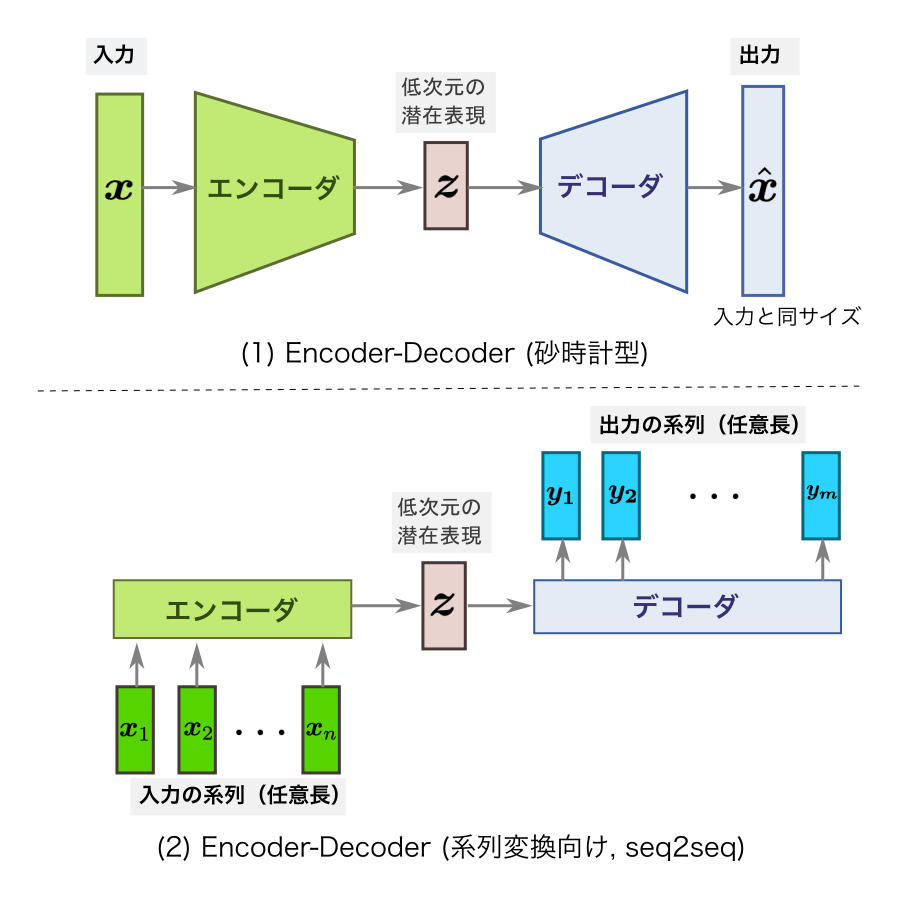

オートエンコーダは、画像の圧縮を通じて、画像の特徴量を抽出する。そのため、入力画像に異常があると、うまく復元できない。この特徴を活かして、オートエンコーダを画像の異常検知に利用することがある。

## **オートエンコーダのネットワーク**
今回は画像xにMNISTの数字画像を使用する。MNISTは２８×２８ピクセルの白黒（チャンネル数は１）の数字の画像。そのため入力層の次元は２８×２８×１=784次元になる。エンコーダは784次元の画像xを200次元の潜在変数（観測できない変数）に圧縮し、続くデコーダは200次元の潜在変数を784次元の画像x'に復元する。エンコーダとデコーダは全結合層を使用し、エンコーダの後に活性化関数ReLU、デコーダの後にSigmoid関数を設定する。復元画像値はSigmoid関数のため、0〜1の値域になる。  

<br>一方、画像xのMNISTは0〜255の256階調（0に近いと黒、255に近いと白）の画素値だが、入力画面（ライブラリ torchvision）の画素値は0〜1の値域に正規化済み。入力画像xと復元画像x'の画素値を0〜1の値域で揃えることで、損失関数による画素値の誤差計算が可能となる。

<br><br>▽オートエンコーダのクラス


```
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(784, 200)
        self.l2 = nn.Linear(200, 784)

    def forward(self, x):
        # エンコーダ
        h = self.l1(x)
        # 活性化関数
        h = torch.relu(h)
        # デコーダ
        h = self.l2(h)
        # シグモイド関数で0〜1の値域に変換
        y = torch.sigmoid(h)

        return y
```



## **オートエンコーダの損失関数**
オートエンコーダは入力画像xと復元画像x'の画素値の誤差をピクセル単位で計算する。この誤差を再構成誤差と呼び、次の式で表せる。

<br><br>$J^{REC}=-\frac{1}{N}\sum_{i=1}^{N}(x_{i} \log y_{i} + (1-x_{i}\log(1-y_{i}))$

<br><br>式の中の$x$はネットワークの入力、$y$は出力で、2つの誤差を最小化するパラメータを計算する。オートエンコーダは正解ラベルがないので教師なし学習だが、入力画像と復元画像の画素値を損失関数で比較できる。

<br><br>入力が与えられた時、出力$y$は次の式になる。

<br><br>$y=\text{sigmoid}(W_{2}f(W_{1x}+b_{1})+b_{2})$

<br><br>
パラメータ$\theta$にはエンコーダとデコーダのパラメータがあり、重み$W_{1}$とバイアス$b_{2}$はエンコーダ、重み$W_{2}$とバイアス$b_{2}$はデコーダのパラメータになる。

<br><br>$\theta=\{W_{1},b_{1},W_{2},b_{2}\}$

<br><br>また活性化関数$f$にはReLUを使用する。

今回の実装では、28×28ピクセルの画像について1ピクセル単位で誤差を計算するため$N$=784になる。

## **オートエンコーダの実装**
オートエンコーダのモデルにクラス**Autoencoder**を使用する。再構成誤差の損失関数はバイナリークロスエントロピーと同じ式になる。なお、ネットワークの最終層にSigmoid関数がある。そのため、損失関数はSigmoid関数の計算を省いたクラス**nn.BCELoss()**を使用する。

<br><br>▽モデル、損失関数、最適化関数の設定
```
# モデルの設定
model = Autoencoder().to(device)

# 損失関数の設定
criterion = nn.BCELoss()

# 最適化関数の設定
optimizer = optim.Adam(model.parameters())
```

<br><br>次は学習のループ処理の実装。今回は10エポックの学習を実行する。1エポックは訓練データを全件網羅することで、train_dataloaderは1回の処理実行（1イテレーション）で全訓練データ（60,000件）の中からバッチサイズ分の件数を取得する。1回のイテレーションで画像$x$をオートエンコーダに入力し。modelは復元画像predsを出力する。損失関数は、入力画像$x$と復元画像predsの画素値をピクセル単位で誤差計算する。続いて、バックプロバケーションで誤差勾配を計算し、パラメータを1イテレーションごとに更新して、次のイテレーションに繋げる。以上の処理が1エポック内のループ処理になり、10エポック分の学習を実行する。

<br><br>▽学習の実行


```
epochs = 10
# エポックのグループ
for epoch in range(epochs):
    train_loss = 0.
    # バッチサイズのグループ
    for (x, _) in train_dataloader:
        x = x.view(x.size(0), -1).to(device)  # バッチ内の各データを1次元に変換
        # 訓練モードへの切り替え
        model.train()
        # 順伝播計算
        preds = model(x)
        # 入力画像xと復元画像predsの誤差計算
        loss = criterion(preds, x)
        # 勾配の初期化
        optimizer.zero_grad()
        # 誤差の勾配計算(バックプロバケーション)
        loss.backward()
        # パラメータの更新
        optimizer.step()
        # 訓練誤差の更新
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)

    print("Epochs: {}, Loss: {:.3f}".format(
         epoch+1,
         train_loss
    ))
```
▽復元画像の表示


```
# dataloaderからデータの取り出し
x, _ = next(iter(test_dataroader))
x = x.view(x.size(0), -1).to(device)  # バッチ内の各データを1次元に変換

# 評価モードへの切り替え
model.eval()

# 復元画像
x_rec = model(x)

# 入力画像、復元画像の表示
for i, image in enumerate([x, x_rec]):
    # 入力画像は1次元のまま表示
    if i == 0:
        image = image.view(-1, 28, 28).detach().cpu().numpy()
    # 復元画像は2次元に変更して表示
    else:
        image = image.view(-1, 28, 28).detach().cpu().numpy()
        
    plt.subplot(1, 2, i+1)
    plt.imshow(image[0], cmap="binary_r")  # 2次元の場合はimage[0]で最初の画像を取得
    plt.axis("off")
plt.show()
```





Epochs: 1, Loss: 0.133
Epochs: 2, Loss: 0.078
Epochs: 3, Loss: 0.071
Epochs: 4, Loss: 0.069
Epochs: 5, Loss: 0.067
Epochs: 6, Loss: 0.067
Epochs: 7, Loss: 0.066
Epochs: 8, Loss: 0.066
Epochs: 9, Loss: 0.066
Epochs: 10, Loss: 0.065


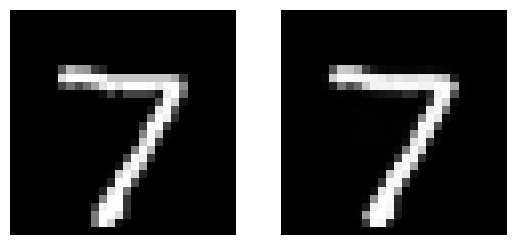

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# デバイスの指定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ハイパーパラメータ
batch_size = 64
learning_rate = 0.001
epochs = 10

# MNISTデータセットの読み込み
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True,
                               transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False,
                              transform=transform, download=True)

# DataLoaderの作成
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(784, 200)
        self.l2 = nn.Linear(200, 784)

    def forward(self, x):
        # エンコーダ
        h = self.l1(x)
        # 活性化関数
        h = torch.relu(h)
        # デコーダ
        h = self.l2(h)
        # シグモイド関数で0〜1の値域に変換
        y = torch.sigmoid(h)

        return y

# モデルの設定
model = Autoencoder().to(device)

# 損失関数の設定
criterion = nn.BCELoss()

# 最適化関数の設定
optimizer = optim.Adam(model.parameters())

epochs = 10
# エポックのグループ
for epoch in range(epochs):
    train_loss = 0.
    # バッチサイズのグループ
    for (x, _) in train_dataloader:
        x = x.view(x.size(0), -1).to(device)
        # 訓練モードへの切り替え
        model.train()
        # 順伝播計算
        preds = model(x)
        # 入力画像xと復元画像predsの誤差計算
        loss = criterion(preds, x)
        # 勾配の初期化
        optimizer.zero_grad()
        # 誤差の勾配計算(バックプロバケーション)
        loss.backward()
        # パラメータの更新
        optimizer.step()
        # 訓練誤差の更新
        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    print("Epochs: {}, Loss: {:.3f}".format(
         epoch+1,
         train_loss
    ))

# dataloaderからデータの取り出し
x, _ = next(iter(test_dataloader))
x = x.view(x.size(0), -1).to(device)  # バッチ内の各データを1次元に変換

# 評価モードへの切り替え
model.eval()

# 復元画像
x_rec = model(x)

# 入力画像、復元画像の表示
for i, image in enumerate([x, x_rec]):
    # 入力画像は1次元のまま表示
    if i == 0:
        image = image.view(-1, 28, 28).detach().cpu().numpy()
    # 復元画像は2次元に変更して表示
    else:
        image = image.view(-1, 28, 28).detach().cpu().numpy()

    plt.subplot(1, 2, i+1)
    plt.imshow(image[0], cmap="binary_r")  # 2次元の場合はimage[0]で最初の画像を取得
    plt.axis("off")
plt.show()